# Assignment 05
***


### K-means clustering 2번째


---
### 모듈 정의


#### 그래프를 그리기 위해 Python3 matplotlib module 을 사용합니다
#### accuracy 측정을 위하여 Counter를 사용합니다.
#### 처음 랜덤한 Centroid를 정하기 위하여 random 사용합니다.

#### 이미지 픽셀의 RGB를 가져오기 위해서 PIL의 Image를 사용합니다.

In [239]:
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import Counter
from PIL import Image

---

## 1. 이미지 선정

- 사용하고자하는 이미지를 선정합니다.



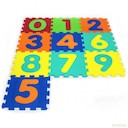

In [240]:
import IPython.display
IPython.display.Image(filename='test.jpg') 

- 이미지의 size와 pixel의 RGB를 가져옵니다. (제대로 RGB값을 가져오는지 보기 위하여 사이즈는 500 by 400이지만 3 by 3만 출력)


In [241]:
im = Image.open('test.jpg')
pix = im.load()
print("-------------------")
print("이미지 사이즈 : (%d,%d)" % (im.size[0],im.size[1]))

print("-------------------")
print("중간 부분에서 3 by 3을 출력")
print("-------------------")
for x in range(64,67):
    for y in range(64,67):
        print(pix[x,y])


-------------------
이미지 사이즈 : (128,128)
-------------------
중간 부분에서 3 by 3을 출력
-------------------
(149, 227, 91)
(231, 237, 49)
(255, 234, 9)
(208, 252, 69)
(242, 248, 54)
(255, 242, 44)
(240, 251, 35)
(251, 255, 47)
(241, 244, 53)


## 2. 필요 함수 선언

---
#### init 함수
- 픽셀에 해당하는 RGB와 클러스터 label을 저장할 matrix를 만듭니다.
- 처음에는 RGB에 해당하는 클러스터 label을 랜덤으로 배정합니다.
- 128 * 128의 사이즈에 해당하는 이미지의 각각의 픽셀과 랜덤으로 배정되는 클러스터 label을 label_matrix에 저장하여 반환합니다

In [242]:
def init(im,pix,K):
    label_matrix = [[0 for y in range(0,im.size[1])] for x in range(0,im.size[0])]
    for x in range(0,im.size[0]):
        for y in range(0,im.size[1]):
            label_matrix[x][y] = (random.randrange(1,K+1),pix[x,y])

    return label_matrix


#### get_pixels_by_label 함수
- 배정받은 클러스터의 label(초기 랜덤으로 배정되거나 centroid 연산으로 결정되는) 별로 pixel을 모읍니다.
- 각각의 label 별로 dic변수에 저장되어 반환해줍니다.
- 결과적으로 반환 값은 label별로 모여 있는 pixel들을 받습니다.

In [243]:
def get_pixels_by_label(im,label_matrix):
    dic = dict()
    for x in range(0,im.size[0]):
        for y in range(0,im.size[1]):
            data = label_matrix[x][y]
            if data[0] not in dic:
                dic[data[0]] = []
                dic[data[0]].append(data[1])
            else:
                dic[data[0]].append(data[1])
    return dic


#### centroid_select 함수
- get_pixels_by_label에서 받은 label별로 모여있는 pixel들의 centroid를 만드는 작업을 합니다.
- 각 label 별로 저장되어있는 모든 pixel의 (R,G,B) 합을 각 label 별로 저장되어있는 모든 pixel의 수로 나눕니다.
- 결과적으로 cluster_centroid에 각 클러스터 별 centroid의 값을 저장하게 됩니다.

In [244]:
def centroid_select(pixels_by_label,cluster_centroid):
    for x in pixels_by_label:
        temp = list(map(list, pixels_by_label[x]))
        centroid = np.sum(np.array(temp), axis = 0) / len(temp)
        cluster_centroid[x] = centroid
    return cluster_centroid


#### image2cluster 함수
- 다시 모든 이미지들의 pixel의 R,G,B 값과 각 클러스터의 centroid와의 거리를 구하여 해당 pixel의 label을 가장 작은 거리의 클러스터 label로 업데이트 해줍니다.

In [245]:
def image2cluster(im,matrix,centroids):
    for x in range(0,im.size[0]):
        for y in range(0,im.size[1]):
            minDist = (99999999,99999999)
            for idx in centroids:
                dist = (np.linalg.norm(matrix[x][y][1] - centroids[idx]),idx)
                if minDist[0] > dist[0]:
                    minDist = dist 
            matrix[x][y] = (minDist[1],matrix[x][y][1])
    return matrix


#### get_energyfunction_val 함수와 show_energyfunction 함수
- energy function의 값을 구하는 함수입니다.


$$ \frac{1}{K}\sum_{k = 1}^K \| x_i - c_{k_i} \|^2 $$
- where $k_i$ denotes the category of $x_i$, and $c_{k_i}$ denotes the centroid of category $x_i$.

위 연산을 구현한 것으로 클러스터별 pixels 와 centroid의 norm을 구하고 클러스터별 value를 모두 더하여 K만큼 나눕니다.

- show_energyfunction는 get_energyfunction_val에서 받은 energy의 값을 가지고 plot을 해주는 함수입니다.

In [246]:
def get_energyfunction_val(cluster,centroids,K): 
    val = 0
    for i in cluster:
        val = val + np.linalg.norm(cluster[i] - cluster_centroid[i])
    return val / K

def show_energyfunction(iter,energy):
    plt.xlabel("iterator")
    plt.ylabel("energy")
    plt.plot(range(0,iter), energy)
    plt.show()


#### save_result 함수
- 클러스터링 연산을 하고 난 후의 정확도를 이미지로 확인하고자 만든 함수입니다.
- iterator 만큼의 연산을 하고 난 후에 각 pixel에 해당하는 label의 해당하는 centroid값을 기존의 pixel 넣어서 이미지를 만듭니다.

In [247]:
def save_result(im,pix,label_matrix,cluster_centroid,K):
    for x in range(0,im.size[0]):
        for y in range(0,im.size[1]):
            pixel = cluster_centroid[label_matrix[x][y][0]]
            pix[x,y] = (int(pixel[0]),int(pixel[1]),int(pixel[2]))
    im.save(str(K)+"_result.png")

## 3. 테스트(Energy 함수와 결과 이미지 비교)

---
### K=3, 5, 7, 10, 15 // iterator = 15

K=3 energy function


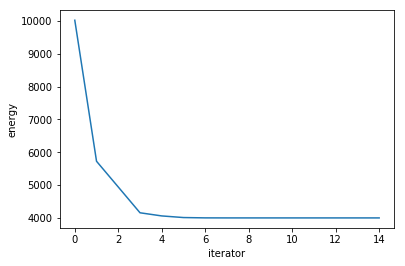

K=5 energy function


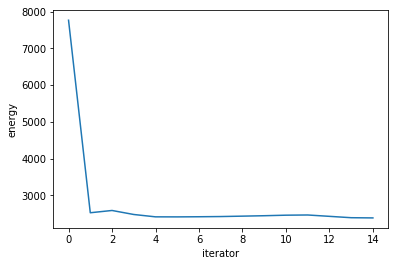

K=7 energy function


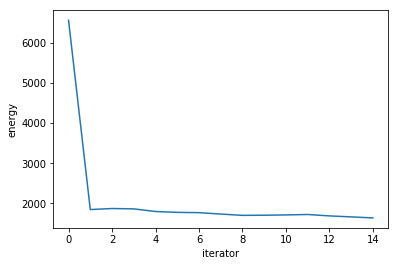

K=10 energy function


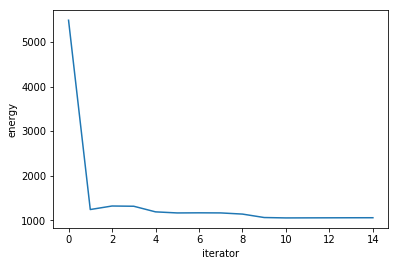

K=15 energy function


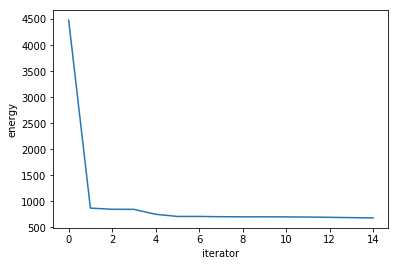

In [248]:

iterator = 15

for K in [3,5,7,10,15]:
    im = Image.open('test.jpg')
    pix = im.load()
    cluster_centroid = dict()
    for i in range(1,K+1):
        cluster_centroid[i] = 0

    label_matrix = [[]]
    label_matrix = init(im,pix,K)


    energy = []
    for x in range(0,iterator):
        pixels_by_label = get_pixels_by_label(im,label_matrix)
        cluster_centroid = centroid_select(pixels_by_label,cluster_centroid)
        label_matrix = image2cluster(im,label_matrix,cluster_centroid)
        energy.append(get_energyfunction_val(pixels_by_label,cluster_centroid,K))

    print("K="+str(K)+" energy function")
    show_energyfunction(iterator,energy)
    save_result(im,pix,label_matrix,cluster_centroid,K)


---
### K=3

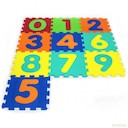

In [249]:
IPython.display.Image("test.jpg") 

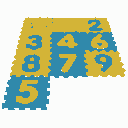

In [251]:
IPython.display.Image("3_result.png") 

---
### K=5

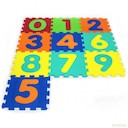

In [252]:
IPython.display.Image("test.jpg") 

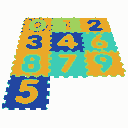

In [253]:
IPython.display.Image("5_result.png") 

---
### K=7

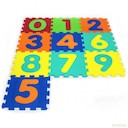

In [254]:
IPython.display.Image("test.jpg") 

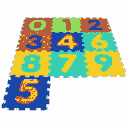

In [255]:
IPython.display.Image("7_result.png") 

---
### K=10

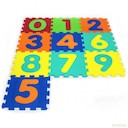

In [256]:
IPython.display.Image("test.jpg") 

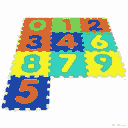

In [257]:
IPython.display.Image("10_result.png") 

---
### K=15

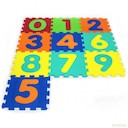

In [258]:
IPython.display.Image("test.jpg") 

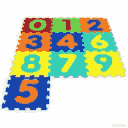

In [259]:
IPython.display.Image("15_result.png") 

## 결과
- 결과적으로 K가 커질 수록 이미지의 표현하는 클러스터가 많아지므로 원본 이미지와 가장 비슷해짐을 알 수 있습니다.
 